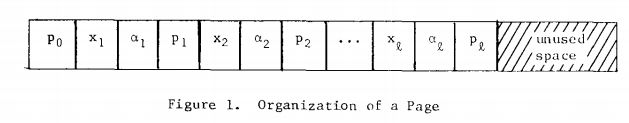

In [ ]:
import math

class Node():
  def __init__(self, parent = None):
    self.parent = parent # Node
    self.keys = []       # integer
    self.values = []     # string
    self.children = []   # Node

  def __str__(self):
    if self.parent == None:
      return 'Root Node!'
    elif not self.children:
      return 'Leaf Node!'
    else:
      return 'Internal Node!'

def binary_search(list_, key): # 이진탐색 함수. 그냥 파이썬 List 내장함수인 list.index()를 사용해도 됨
  low = 0
  high = len(list_)-1
  while high >= low:
    mid = (low+high)//2
    if key<list_[mid]:
      high = mid-1
    elif key == list_[mid]:
      return mid
    else:
      low = mid+1
  return low

def search_location(node,key):
  loc = binary_search(node.keys, key)
  if loc < len(node.keys) and node.keys[loc] == key: # Node안에 key 이미 존재
    return True, node, loc # key 찾았다, 이 node의 이 location에 있다
  else: # Node안에 key 없음
    if not node.children: # node가 leaf임
      return False, node, loc # 다 찾아봤는데 없더라, insertion할거면 이 node에 이 location이다.
    else: # node가 leaf가 아님
      return search_location(node.children[loc], key) # 그럼 더 내려가보자

class BTree():
  def __init__(self, m):
    self.root = Node()
    self.m = m # 최대 자식노드수 = FanOut
    self.least_key_num = math.floor(m/2) if m%2==1 else int(m/2) -1

  def insertion(self, key, value):
    #print('insert', key)
    root = self.root
    key_already_exists, node, loc = search_location(root, key) # 트리 내 존재여부, 있어야할 노드, 노드내 위치
    if key_already_exists:
      print("Error! key already exists") # insertion하려 했는데 이미 존재
    else:
      node.keys.insert(loc, key)
      node.values.insert(loc, value)
    
    if len(node.keys) == self.m: # node overflow
      self.split(node)
  
  def split(self, node):
    new_sibling = Node(node.parent) # 형제노드 생성
    loc = self.least_key_num+1 # 여기 수정 필요 있는듯
    #if (self.m+1)%2 == 0: # 짝수일 경우 이거 해줘야함 
    #  loc+=1

    mid_key = node.keys[loc-1] # 위로 올릴 key
    mid_value = node.values[loc-1] # 위로 올릴 value
    
    # 반띵
    new_sibling.keys += node.keys[loc:]
    new_sibling.values += node.values[loc:]
    new_sibling.children += node.children[loc:]

    for child in new_sibling.children: # children에게도 부모가 바뀐걸 알려줌
      child.parent = new_sibling

    del node.keys[loc-1:]
    del node.values[loc-1:]
    del node.children[loc:] # 반띵 끝

    if node.parent == None: # 반띵한게 root임
      new_root = Node()
      new_root.keys.append(mid_key)
      new_root.values.append(mid_value)
      new_root.children.append(node)
      new_root.children.append(new_sibling)
      node.parent = new_root
      new_sibling.parent = new_root
      self.root = new_root
    else: # 반띵한게 root가 아님
      parent_loc = binary_search(node.parent.keys, mid_key) # 올릴 친구 자리찾기 이거는 node.parent.children.index(node)로 해도 됨
      node.parent.keys.insert(parent_loc, mid_key)
      node.parent.values.insert(parent_loc, mid_value)
      node.parent.children.insert(parent_loc+1, new_sibling)
      if len(node.parent.keys) > self.m-1: # 부모노드 overflow
        self.split(node.parent)

  def deletion(self, start_node, key):
    #print('delete', key)
    Found, node, loc = search_location(start_node, key)
    if Found:
      if 0 < len(node.children): # leaf가 아니다.
        if len(node.children[loc].keys) == self.least_key_num: # 왼쪽이 최소키
          if len(node.children[loc+1].keys) == self.least_key_num: # 오른쪽도 최소키
            #두 자식 노드 merge (훗날의 underflow 처리에 연쇄 방지턱)
            left_child = node.children[loc]
            right_child = node.children[loc+1]
            left_child.keys.append(key) # 자식에게 삭제할 키 준다
            left_child.values.append(node.values[loc])
            left_child.keys += right_child.keys # 오른쪽거 왼쪽에게
            left_child.values += right_child.values
            left_child.children += right_child.children
            for child in right_child.children:
              child.parent = left_child
            del node.children[loc+1] # 오른쪽 삭제
            del node.keys[loc]   # 기존 삭제
            del node.values[loc]
            if node.parent == None and not node.keys: # 루트가 비워졌다 -> 루트 옮긴다
              left_child.parent = None
              self.root = left_child
            return self.deletion(left_child, key)
          else: # 왼쪽만 최소키
            leaf_cand = node.children[loc+1] # Go to Right~
            while 0 < len(leaf_cand.children):
              leaf_cand = leaf_cand.children[0]
            node.keys[loc] = leaf_cand.keys[0]
            node.values[loc] = leaf_cand.values[0]
            node = leaf_cand
            loc = 0
        else: # 둘다 최소키 아니거나 오른쪽이 최소키
          leaf_cand = node.children[loc] # Go to Left!
          while 0 < len(leaf_cand.children):
            leaf_cand = leaf_cand.children[len(leaf_cand.children)-1]
          node.keys[loc] = leaf_cand.keys[len(leaf_cand.children)-1]
          node.values[loc] = leaf_cand.values[len(leaf_cand.children)-1]
          node = leaf_cand
          loc = len(leaf_cand.children)-1
      del node.keys[loc]  
      del node.values[loc]

      if len(node.keys) < self.least_key_num and node.parent is not None: # node underflow
        self.clear_underflow(node)

    else:
      print("Error! key does not exists")

  def clear_underflow(self, node):
    if not node.children:
      # Leaf Node
      isLeaf = True
    else:
      # Internal Node
      isLeaf = False

    parent = node.parent
    node_loc = binary_search(parent.keys, node.keys[0])
    
    # 형제가 어디에 존재?(좌, 우)
    if node_loc == 0:
      target_sibling = parent.children[1]
      sibling_is_rightside = True
    elif node_loc == len(parent.children)-1:
      target_sibling = parent.children[node_loc-1]
      sibling_is_rightside = False
    else: # 형제가 양쪽에 존재 -> 키가 더 많은애를 고르자
      if len(parent.children[node_loc-1].keys) > len(parent.children[node_loc+1].keys):
        target_sibling = parent.children[node_loc-1]
        sibling_is_rightside = False
      else:
        target_sibling = parent.children[node_loc+1]
        sibling_is_rightside = True

    if len(target_sibling.keys) == self.least_key_num: # 형제도 최소치임 -> merge
      if sibling_is_rightside:
        node.keys.append(parent.keys.pop(node_loc))
        node.values.append(parent.values.pop(node_loc))
        node.keys += target_sibling.keys
        node.values += target_sibling.values
        if not isLeaf:
          node.children += target_sibling.children 
          for child in target_sibling.children :
            child.parent = node # 자식들 parent도 바꿔줌
        del parent.children[node_loc+1]
      else: # 형제가 왼쪽
        target_sibling.keys.append(parent.keys.pop(node_loc-1))
        target_sibling.values.append(parent.values.pop(node_loc-1))
        target_sibling.keys += node.keys
        target_sibling.values += node.values
        if not isLeaf:
          target_sibling.children += node.children 
          for child in node.children :
            child.parent = target_sibling
        del parent.children[node_loc]

      # merge했더니 부모가 underflow
      if len(parent.keys) < self.least_key_num and parent.parent is not None:
        self.clear_underflow(parent)
        
    else: # 형제 거 1개 가져오기
      if sibling_is_rightside:
        node.keys.append(parent.keys[node_loc])
        node.values.append(parent.values[node_loc])
        parent.keys[node_loc] = target_sibling.keys.pop(0)
        parent.values[node_loc] = target_sibling.values.pop(0)
        if not isLeaf: # internal node이면 형제 자식노드(트리) 하나도 데려옴
          target_sibling.children[0].parent = node
          node.children.append(target_sibling.children.pop(0))
      else: # 형제가 왼쪽
        node.keys.insert(0, parent.keys[node_loc-1])
        node.values.insert(0, parent.values[node_loc-1])
        parent.keys[node_loc-1] = target_sibling.keys.pop()
        parent.values[node_loc-1] = target_sibling.values.pop()
        if not isLeaf: 
          node.children.insert(0, target_sibling.children.pop())
          node.children[0].parent = node

  def search(self, key):
    root = self.root
    key_exists, node, loc = search_location(root, key)
    if key_exists:
      return (node.keys[loc], node.values[loc])
    else:
      #print("Key does not exists")
      return -1

In [ ]:
def print_(A):
  print(A.root.keys)
  for i in A.root.children:
    print(i.keys, end=' // ')
  print()
  if 0 < len(A.root.children):
    for i in A.root.children:
      if 0 < len(i.children):
        for j in i.children:
          print(j.keys,end=' ')
      print(end=' // ')
  print('')

A = BTree(6)
A.insertion(7, 0)
A.insertion(13, 0)
A.insertion(25, 0)
print_(A)
A.insertion(34, 0)
A.insertion(1, 0)
print_(A)
A.insertion(2, 0)
print_(A)
A.insertion(3, 0)
A.insertion(4, 0)
print_(A)
A.insertion(6, 0)
A.insertion(8, 0)
A.insertion(10, 0)
A.insertion(15, 0)
print_(A)
A.insertion(17, 0)
A.insertion(19, 0)
A.insertion(20, 0)
A.insertion(27, 0)
print_(A)
A.insertion(28, 0)
print_(A)
A.insertion(30, 0)
print_(A)
A.insertion(33, 0)
print_(A)
A.insertion(37, 0)
print_(A)
A.insertion(38, 0)
print_(A)
A.insertion(40, 0)
A.insertion(41, 0)
A.insertion(45, 0)
print_(A)
#A.display()
A.deletion(A.root, 45)
print_(A)

A.deletion(A.root, 40)
print_(A)

A.deletion(A.root, 6)
print_(A)

A.deletion(A.root, 19)
print_(A)

insert 7
insert 13
insert 25
[7, 13, 25]


insert 34
insert 1
[1, 7, 13, 25, 34]


insert 2
[7]
[1, 2] // [13, 25, 34] // 
 //  // 
insert 3
insert 4
[7]
[1, 2, 3, 4] // [13, 25, 34] // 
 //  // 
insert 6
insert 8
insert 10
insert 15
[7, 13]
[1, 2, 3, 4, 6] // [8, 10] // [15, 25, 34] // 
 //  //  // 
insert 17
insert 19
insert 20
insert 27
[7, 13, 19]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25, 27, 34] // 
 //  //  //  // 
insert 28
[7, 13, 19]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25, 27, 28, 34] // 
 //  //  //  // 
insert 30
[7, 13, 19, 27]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25] // [28, 30, 34] // 
 //  //  //  //  // 
insert 33
[7, 13, 19, 27]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25] // [28, 30, 33, 34] // 
 //  //  //  //  // 
insert 37
[7, 13, 19, 27]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25] // [28, 30, 33, 34, 37] // 
 //  //  //  //  // 
insert 38
[7, 13, 19, 27, 33]
[1, 2, 3, 4, 6] // [8, 10] // [15, 17] // [20, 25] // [28, 30] /